In [1]:
import sys
sys.path.append('./weightflow')  # e.g., './repo_name'

import numpy as np
from collections import defaultdict
from typing import NamedTuple
from scipy.optimize import linear_sum_assignment

# from nn.relational_transformer import RelationalTransformer
# from nn.graph_constructor import GraphConstructor
from flow.flow_matching import CFM
from tqdm import tqdm
import copy
import logging
from utils.data import sample_gaussian_wsos
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
import os
import traceback
from types import SimpleNamespace
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATConv, GraphNorm, GCNConv, GraphSAGE
from torch_geometric.loader import DataLoader as PyGDataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(stream=sys.stdout, format='%(asctime)s %(levelname)s: %(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [2]:
# PermutationSpec class similar to the JAX version but using PyTorch
class PermutationSpec(NamedTuple):
    perm_to_axes: dict
    axes_to_perm: dict

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
    perm_to_axes = defaultdict(list)
    for wk, axis_perms in axes_to_perm.items():
        for axis, perm in enumerate(axis_perms):
            if perm is not None:
                perm_to_axes[perm].append((wk, axis))
    return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec_mlp() -> PermutationSpec:
    """Define permutation spec for MLP architecture"""
    return permutation_spec_from_axes_to_perm({
        "fc1.weight": (None, "P_0"),       # Input (None) to fc1 output (P_0)
        "fc1.bias": ("P_0",),              # Bias for fc1 output (P_0)
        "fc2.weight": ("P_0", "P_1"),      # fc1 output (P_0) to fc2 output (P_1)
        "fc2.bias": ("P_1",),              # Bias for fc2 output (P_1)
        "fc3.weight": ("P_1", None),       # fc2 output (P_1) to fc3 output (None)
        "fc3.bias": (None,),               # Bias for fc3 output (None)
    })

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
    """Get parameter k from params, with permutations applied."""
    w = params[k]
    for axis, p in enumerate(ps.axes_to_perm[k]):
        # Skip the axis we're trying to permute
        if axis == except_axis:
            continue

        # None indicates no permutation for that axis
        if p is not None:
            w = torch.index_select(w, axis, torch.tensor(perm[p], device=w.device))

    return w

def apply_permutation(ps: PermutationSpec, perm, params):
    """Apply permutation to params"""
    return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None, silent=True, device=None):
    """Find permutation of params_b to make them match params_a."""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move all tensors to the correct device
    params_a = {k: v.to(device) for k, v in params_a.items()}
    params_b = {k: v.to(device) for k, v in params_b.items()}

    # Get permutation sizes from the first parameter with each permutation
    perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] 
                  for p, axes in ps.perm_to_axes.items()}
    
    # Initialize permutations to identity if none provided
    if init_perm is None:
        perm = {p: torch.arange(n, device=device) for p, n in perm_sizes.items()}
    else:
        perm = {p: v.to(device) for p, v in init_perm.items()}
        
    perm_names = list(perm.keys())
    
    # Use a random number generator with a fixed seed for reproducibility
    rng = np.random.RandomState(42)

    for iteration in range(max_iter):
        progress = False
        
        # Shuffle the order of permutations to update
        for p_ix in rng.permutation(len(perm_names)):
            p = perm_names[p_ix]
            n = perm_sizes[p]
            
            # Initialize cost matrix
            A = torch.zeros((n, n), device=device)
            
            # Fill in cost matrix based on all parameters affected by this permutation
            for wk, axis in ps.perm_to_axes[p]:
                w_a = params_a[wk]
                w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)

                w_a = w_a.moveaxis(axis, 0).reshape((n, -1))
                w_b = w_b.moveaxis(axis, 0).reshape((n, -1))

                A += w_a @ w_b.T

            # Solve the linear assignment problem
            ri, ci = linear_sum_assignment(A.detach().cpu().numpy(), maximize=True)
            assert (ri == np.arange(len(ri))).all()

            # Calculate improvement
            eye_old = torch.eye(n, device=device)[perm[p]]
            eye_new = torch.eye(n, device=device)[ci]

            oldL = torch.tensordot(A, eye_old, dims=([0, 1], [0, 1]))
            newL = torch.tensordot(A, eye_new, dims=([0, 1], [0, 1]))

            if not silent and newL > oldL + 1e-12:
                logging.info(f"{iteration}/{p}: {newL.item() - oldL.item()}")

            progress = progress or newL > oldL + 1e-12

            perm[p] = torch.tensor(ci, device=device)

        if not progress:
            break

    return perm


def update_model_weights(model, aligned_params):
    """Update model weights with aligned parameters"""
    # Convert numpy arrays to torch tensors if needed
    model.fc1.weight.data = aligned_params["fc1.weight"].T
    model.fc1.bias.data = aligned_params["fc1.bias"]
    model.fc2.weight.data = aligned_params["fc2.weight"].T
    model.fc2.bias.data = aligned_params["fc2.bias"]
    model.fc3.weight.data = aligned_params["fc3.weight"].T
    model.fc3.bias.data = aligned_params["fc3.bias"]
    
def load_model_weights(model, model_path):
    """Load model weights from file"""
    weights, biases = torch.load(model_path, map_location=device)
    model.fc1.weight.data = weights[0]
    model.fc1.bias.data = biases[0]
    model.fc2.weight.data = weights[1]
    model.fc2.bias.data = biases[1]
    model.fc3.weight.data = weights[2]
    model.fc3.bias.data = biases[2]
    return model.to(device)

def get_permuted_models_data(ref_point=0, model_dir="models", num_models=200, model_type = f'MNIST'):
    """Apply weight matching to align models with a reference model"""
    # Create reference model
    ref_model = MLP()  # Assumes MLP class is defined
    ref_model_path = f"{model_dir}/{model_type}_mixed_mlp_weights_{ref_point}.pt"
    ref_model = load_model_weights(ref_model, ref_model_path).to(device)
    
    ps = mlp_permutation_spec_mlp()
    
    # Convert reference model weights to dictionary format
    params_a = {
        "fc1.weight": ref_model.fc1.weight.T.to(device),
        "fc1.bias": ref_model.fc1.bias.to(device),
        "fc2.weight": ref_model.fc2.weight.T.to(device),
        "fc2.bias": ref_model.fc2.bias.to(device),
        "fc3.weight": ref_model.fc3.weight.T.to(device),
        "fc3.bias": ref_model.fc3.bias.to(device),
    }
    
    org_models = []
    permuted_models = []

    for i in range(0, num_models):
        if i == ref_point:
            continue
            
        model_path = f"{model_dir}/{model_type}_mixed_mlp_weights_{i}.pt"

        model = MLP()  # Assumes MLP class is defined
        model = load_model_weights(model, model_path).to(device)
        org_models.append(model)
        
        # Convert model weights to dictionary format
        params_b = {
                "fc1.weight": model.fc1.weight.T.to(device),
                "fc1.bias": model.fc1.bias.to(device),
                "fc2.weight": model.fc2.weight.T.to(device),
                "fc2.bias": model.fc2.bias.to(device),
                "fc3.weight": model.fc3.weight.T.to(device),
                "fc3.bias": model.fc3.bias.to(device),
        }

        # Find permutation to align with reference model
        perm = weight_matching(ps, params_a, params_b)
        
        # Apply permutation to model_b
        aligned_params_b = apply_permutation(ps, perm, params_b)
        
        # Create a new model with permuted weights
        reconstructed_model = copy.deepcopy(model)
        update_model_weights(reconstructed_model, aligned_params_b)
        
        permuted_models.append(reconstructed_model.to(device))

            
    return ref_model, org_models, permuted_models



In [3]:
# Define MNIST classifier MLP class for dataset
class MLP(nn.Module):
    """
    A fully connected 3 layer neural network for classification tasks where hidden layers have 32 neurons (default) and ReLU activations
    input: torch.tensor( [batch_size, 196] )
    output: torch.tensor( [batch_size, 10] )
    For classifying inputs of 196 into 10 classes.
    """
    def __init__(self, hidden_dim = 32, init_type='xavier', seed=None, type = 'MNIST'):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(196, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)
        self.type = type

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



def test_mlp(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    model = model.to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def zero_like_wso(wso):
    zero_weights = tuple(torch.zeros_like(w) for w in wso.weights)
    zero_biases = tuple(torch.zeros_like(b) for b in wso.biases)
    return WeightSpaceObject(zero_weights, zero_biases)

# WeightSpaceObject class for handling MLP weights
class WeightSpaceObject:
    def __init__(self, weights, biases):
        self.weights = weights if isinstance(weights, tuple) else tuple(weights)
        self.biases = biases if isinstance(biases, tuple) else tuple(biases)
        
    def flatten(self, device=None):
        """Flatten weights and biases into a single vector"""
        flat = torch.cat([w.flatten() for w in self.weights] + 
                          [b.flatten() for b in self.biases])
        if device:
            flat = flat.to(device)
        return flat
    
    @classmethod
    def from_flat(cls, flat, layers, device):
        """Create WeightSpaceObject from flattened vector"""
        sizes = []
        # Calculate sizes for weight matrices
        for i in range(len(layers) - 1):
            sizes.append(layers[i] * layers[i+1])  # Weight matrix
        # Calculate sizes for bias vectors
        for i in range(1, len(layers)):
            sizes.append(layers[i])  # Bias vector
            
        # Split flat tensor into parts
        parts = []
        start = 0
        for size in sizes:
            parts.append(flat[start:start+size])
            start += size
            
        # Reshape into weight matrices and bias vectors
        weights = []
        biases = []
        for i in range(len(layers) - 1):
            w_size = layers[i] * layers[i+1]
            weights.append(parts[i].reshape(layers[i+1], layers[i]))
            biases.append(parts[i + len(layers) - 1])
            
        return cls(weights, biases).to(device)
    
    def to(self, device):
        """Move weights and biases to specified device"""
        weights = tuple(w.to(device) for w in self.weights)
        biases = tuple(b.to(device) for b in self.biases)
        return WeightSpaceObject(weights, biases)
        
    def map(self, fn):
        new_weights = tuple(fn(w) for w in self.weights)
        new_biases = tuple(fn(b) for b in self.biases)
        return WeightSpaceObject(new_weights, new_biases)

# Simple Bunch class for storing data
class Bunch:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# Safe deflatten function that checks bounds before accessing tensors
def safe_deflatten(flat, batch_size, starts, ends):
    """Safely deflatten a tensor without index errors"""
    parts = []
    actual_batch_size = flat.size(0)
    
    # Ensure we don't exceed the actual batch size
    safe_batch_size = min(actual_batch_size, batch_size)
    
    for i in range(safe_batch_size):
        batch_parts = []
        for si, ei in zip(starts, ends):
            if si < ei:  # Only process valid ranges
                batch_parts.append(flat[i][si:ei])
        parts.append(batch_parts)
    
    return parts


In [4]:
class MLPGraphDataset(torch.utils.data.Dataset):
    """
    Torch Dataset of MLPs converted to graph‐structured Data with:

      - Node features: [bias_value, one_hot_node_layer]
      - Edge features: [weight_value, one_hot_edge_layer]

    Ordering of nodes in each graph: 
      • nodes 0..(input_dim−1)                    → “input nodes” (layer_id = 0, bias_value = 0)
      • next `layer_sizes[1]` nodes                → biases of layer 1 (layer_id = 1)
      • next `layer_sizes[2]` nodes                → biases of layer 2 (layer_id = 2)
      • next `layer_sizes[3]` nodes                → biases of layer 3 (layer_id = 3)

    Ordering of edges in each graph is exactly:
      For layer ℓ = 1..3, in order:
        for i_out in range(out_dim_ℓ):
          for j_in in range(in_dim_ℓ):
            add edge (src = node_offset + j_in, dst = node_offset + in_dim_ℓ + i_out)
      which matches the weight‐matrix flatten order.
    """

    def __init__(self, mlp_list, layer_sizes):
        """
        Args:
          mlp_list     : list of MLP models, each having attributes `fc1.weight/bias`,
                         `fc2.weight/bias`, `fc3.weight/bias`.
          layer_sizes  : List[int], e.g. [input_dim, hidden1, hidden2, output_dim].
                         The number of weight layers is len(layer_sizes)−1 (i.e. 3).
        """
        super().__init__()
        self.models = mlp_list
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes) - 1  # For [784,512,256,10], num_layers = 3

    def __len__(self):
        return len(self.models)

    def __getitem__(self, idx):
        mlp = self.models[idx]

        # Extract weight & bias tensors from fc1, fc2, fc3
        weights = [mlp.fc1.weight, mlp.fc2.weight, mlp.fc3.weight]  # shapes: [out_dim, in_dim]
        biases  = [mlp.fc1.bias,   mlp.fc2.bias,   mlp.fc3.bias]    # shapes: [out_dim]

        input_dim = self.layer_sizes[0]  # e.g. 784
        total_nodes = input_dim + sum(self.layer_sizes[1:])  # 784 + 512 + 256 + 10
        node_feats_list = []
        node_layer_list = []

        # === Build node features ===
        # 1) Input nodes (layer_id = 0), bias_value = 0
        for i in range(input_dim):
            node_feats_list.append([0.0])      # bias_value = 0 for input nodes
            node_layer_list.append(0)          # layer_id = 0

        # 2) Bias nodes for each layer ℓ = 1..num_layers
        for layer_id in range(1, self.num_layers + 1):
            b = biases[layer_id - 1]           # bias tensor of shape [layer_sizes[layer_id]]
            for j in range(self.layer_sizes[layer_id]):
                node_feats_list.append([b[j].item()])
                node_layer_list.append(layer_id)

        # Convert to tensors
        x = torch.tensor(node_feats_list, dtype=torch.float)       # [total_nodes, 1]
        node_layer_tensor = torch.tensor(node_layer_list, dtype=torch.long)  # [total_nodes]

        # One‐hot encode node_layer_tensor (dim = num_layers + 1)
        node_layer_one_hot = F.one_hot(node_layer_tensor, num_classes=self.num_layers + 1).float()
        # Final node features: [bias_value, one_hot_layer] → dim = 1 + (num_layers + 1)
        x = torch.cat([x, node_layer_one_hot], dim=-1)  # [total_nodes, 1 + (num_layers+1)]

        # === Build edges and edge attributes ===
        edge_index_list = []
        edge_attr_list = []
        edge_weight_list = []
        node_offset = 0

        for layer_id, w in enumerate(weights, start=1):
            out_dim, in_dim = w.shape
            for i_out in range(out_dim):
                for j_in in range(in_dim):
                    src = node_offset + j_in
                    dst = node_offset + in_dim + i_out
                    edge_index_list.append([src, dst])

                    weight_val = w[i_out, j_in].item()
                    one_hot_edge = torch.zeros(self.num_layers)  # length = num_layers
                    one_hot_edge[layer_id - 1] = 1.0
                    edge_attr_list.append(torch.cat([torch.tensor([weight_val]), one_hot_edge], dim=0))
                    edge_weight_list.append(torch.tensor([weight_val]))
            node_offset += in_dim

        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()  # [2, E]
        edge_attr  = torch.stack(edge_attr_list, dim=0)  # [E, 1 + num_layers]
        edge_weight = torch.stack(edge_weight_list, dim = 0)
        # For a single‐graph item, batch = all zeros (every node → graph 0)
        batch = torch.zeros(x.size(0), dtype=torch.long)

        return Data(x=x, edge_index=edge_index, edge_weight = edge_weight, edge_attr=edge_attr, batch=batch)


class GraphFlowNet(nn.Module):
    """
    A GAT‐based conditional flow net that predicts BOTH:
      • edge flows (Δweight per edge)
      • node flows (Δbias per node)

    Conditioning on:
      • t ∈ [0,1] (time)
      • c ∈ {0,1,…,C-1} (graph type / class index)

    Architecture summary:
      1) Embed t → t_emb ∈ ℝ^{t_embed_dim}
      2) Embed c → c_emb ∈ ℝ^{class_embed_dim}
      3) Initial node MLP: [node_feat‖t_emb_node‖c_emb_node] → hidden_dim
      4) Initial edge MLP: [edge_attr‖t_emb_edge‖c_emb_edge] → hidden_dim
      5) K× GATConv layers (each uses edge‐features for attention)
      6) Node‐head: Δbias_i = node_out([h_i^K‖t_emb_node‖c_emb_node])
      7) Edge‐head: Δweight_e = edge_out([h_u^K‖h_v^K‖e^0_e‖t_emb_edge‖c_emb_edge])
    """

    def __init__(
        self,
        node_in_channels: int,
        edge_in_channels: int,
        num_classes: int,
        t_embed_dim: int = 16,
        class_embed_dim: int = 16,
        hidden_dim: int = 128,
        num_message_passing_layers: int = 3,
        heads: int = 4,
    ):
        """
        Args:
          node_in_channels            : dimension of initial node feat (e.g. 1 + (num_layers+1))
          edge_in_channels            : dimension of initial edge feat (e.g. 1 + num_layers)
          num_classes                 : total # of graph types / classes (C)
          t_embed_dim                 : dim of time embedding
          class_embed_dim             : dim of graph‐type embedding
          hidden_dim                  : hidden dimension used throughout
          num_message_passing_layers  : how many GATConv layers to stack
          heads                       : # attention heads per GATConv
        """
        super().__init__()
        self.t_embed_dim      = t_embed_dim
        self.class_embed_dim  = class_embed_dim
        self.hidden_dim       = hidden_dim
        self.num_layers_mp    = num_message_passing_layers
        self.num_classes      = num_classes

        # 1) Time embedding: ℝ → ℝ^{t_embed_dim}
        self.time_embed = nn.Sequential(
            nn.Linear(1, t_embed_dim),
        )

        # 2) Class embedding: {0,…,C−1} → ℝ^{class_embed_dim}
        self.class_emb = nn.Embedding(num_classes, class_embed_dim)

        # 3) Initial node projection: [node_feat || t_emb_node || c_emb_node] → hidden_dim
        self.node_proj = nn.Linear(node_in_channels + t_embed_dim + class_embed_dim, hidden_dim)

        # 4) Initial edge projection: [edge_attr || t_emb_edge || c_emb_edge] → hidden_dim
        self.edge_proj = nn.Linear(edge_in_channels + t_embed_dim + class_embed_dim, hidden_dim)


        # 5) Norm -> GraphSAGE -> Norm
        # self.norm1 = GraphNorm(hidden_dim)
        self.norm2 = GraphNorm(hidden_dim)

        # Graph SAGE stack with jumping knowledge
        self.graph_sage = GraphSAGE(in_channels = hidden_dim, hidden_channels = hidden_dim,
                                    num_layers = num_message_passing_layers, out_channels = hidden_dim,
                                   jk = "max")
        
        # 5) Stacked GATConvs (each uses edge_dim = hidden_dim to inject edge embeddings)
        # self.convs = nn.ModuleList()
        # self.norms = nn.ModuleList()
        # for _ in range(num_message_passing_layers):
        #     # consider another method to avoid exploding neighborhood problem - Zohair. 
        #     conv = GCNConv(
        #         in_channels = hidden_dim, 
        #         out_channels = hidden_dim, 
        #         normalize = False, 
        #         add_self_loops = False,
        #     )
        #     # conv = GATConv(
        #     #     in_channels=hidden_dim,
        #     #     out_channels=hidden_dim // heads,
        #     #     heads=heads,
        #     #     concat=True,
        #     #     edge_dim=hidden_dim,
        #     #     dropout=0.0,
        #     #     add_self_loops=False,
        #     # )
        #     norm = GraphNorm(hidden_dim)
        #     self.convs.append(conv)
        #     self.norms.append(norm)

        # 6) Node‐flow head: [h_i^K || t_emb_node || c_emb_node] → Δbias_i (scalar)
        self.node_out_mlp = nn.Sequential(
            nn.Linear(hidden_dim + t_embed_dim + class_embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

        # 7) Edge‐flow head: [h_u^K || h_v^K || e⁰_e || t_emb_edge || c_emb_edge] → Δweight_e (scalar)
        self.edge_out_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim + hidden_dim + t_embed_dim + class_embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, data: Data, t: torch.Tensor, c: torch.Tensor):
        """
        Args:
          data : PyG Data (or Batch) with fields:
                   • x         [N_total, node_in_channels]
                   • edge_index[2, E_total]
                   • edge_attr [E_total, edge_in_channels]
                   • batch     [N_total]   (maps each node→graph index)
          t    : [num_graphs, 1] tensor (each in [0,1])
          c    : [num_graphs]     LongTensor (each ∈ {0,1,…,C−1})

        Returns:
          node_flows : [N_total, 1] predicted Δbias per node
          edge_flows : [E_total, 1] predicted Δweight per edge
        """
        device = data.x.device

        # 1) Compute time‐embeddings for each graph ⇒ [num_graphs, t_embed_dim]
        batch = data.batch                             # [N_total]
        num_graphs = int(batch.max().item()) + 1
        if t.dim() == 1:
            t = t.view(num_graphs, 1)                  # ensure shape = [num_graphs, 1]
        t_emb_graph = self.time_embed(t.to(device))    # [num_graphs, t_embed_dim]

        # 2) Compute class‐embeddings for each graph ⇒ [num_graphs, class_embed_dim]
        c = c.to(device)                               # [num_graphs]
        c_emb_graph = self.class_emb(c)                # [num_graphs, class_embed_dim]

        # 3) Broadcast t_emb & c_emb to nodes:
        t_emb_nodes = t_emb_graph[batch]               # [N_total, t_embed_dim]
        c_emb_nodes = c_emb_graph[batch]               # [N_total, class_embed_dim]

        # 4) Initial node embedding: concat [x, t_emb_node, c_emb_node] → project → ELU
        h = torch.cat([data.x, t_emb_nodes, c_emb_nodes], dim=-1)  # [N_total, node_in_ch + t + c]
        h = self.node_proj(h)                                          # [N_total, hidden_dim]
        # h = F.relu(h)

        # 5) Broadcast t_emb & c_emb to edges via source‐node index:
        src_nodes     = data.edge_index[0]                # [E_total]
        edge_graph_idx = batch[src_nodes]                 # [E_total]
        t_emb_edges   = t_emb_graph[edge_graph_idx]       # [E_total, t_embed_dim]
        c_emb_edges   = c_emb_graph[edge_graph_idx]       # [E_total, class_embed_dim]

        # 6) Initial edge embedding: [edge_attr, t_emb_edge, c_emb_edge] → project → ELU
        e_in = torch.cat([data.edge_attr, t_emb_edges, c_emb_edges], dim=-1)
        e   = self.edge_proj(e_in)   # [E_total, hidden_dim]
        # e   = F.relu(e)

        # 7) K layers of GATConv (edge‐conditioned)
        # for conv, norm in zip(self.convs, self.norms):
            
        #     h1 = conv(h, edge_index = data.edge_index, edge_weight = data.edge_weight)
        #     h = F.relu(norm(h1)) + h
            
        #     # h1, attn_weights = conv(h, data.edge_index, edge_attr=e, return_attention_weights = True)   # [N_total, hidden_dim]
        #     # h1 = norm(h1)
        #     # e = e + F.relu(attn_weights[1])
        #     # h = h + F.relu(h1) 

        # 7) Norm and K layer Graph SAGE sandiwch
        # edge_weight = data.edge_weight,  - bc edge weight and edge_index have different dims. 
        # num_sampled_nodes_per_hop = 12, num_sampled_edges_per_hop = 256 - bc I can't have both / they break things :/
        
        h = self.graph_sage(h, edge_index = data.edge_index,
                            edge_attr = e, num_sampled_nodes_per_hop = 1
                        )
        # h = self.norm2(h)
        
        # 8) Node‐flow head: Δbias_i = node_out_mlp([h_i^K, t_emb_node_i, c_emb_node_i])
        node_head_in = torch.cat([h, t_emb_nodes, c_emb_nodes], dim=-1)  # [N_total, hidden_dim + t + c]
        node_flows = self.node_out_mlp(node_head_in)                     # [N_total, 1]

        # 9) Edge‐flow head: Δweight_e = edge_out_mlp([h_u, h_v, e⁰_e, t_emb_edge, c_emb_edge])
        h_u = h[src_nodes]                             # [E_total, hidden_dim]
        dst_nodes = data.edge_index[1]                 # [E_total]
        h_v = h[dst_nodes]                             # [E_total, hidden_dim]
        edge_head_in = torch.cat([h_u, h_v, e, t_emb_edges, c_emb_edges], dim=-1)
        edge_flows = self.edge_out_mlp(edge_head_in)   # [E_total, 1]

        return node_flows, edge_flows


def flatten_batch_params(batch_data: Batch,
                         node_flows: torch.Tensor,
                         edge_flows: torch.Tensor,
                         layer_sizes: list):
    """
    Helper function to convert a batched graph’s predicted node_flows and edge_flows
    into a tensor of shape [batch_size, flat_dim], where flat_dim = total # of parameters
    in each MLP (i.e. sum over ℓ=1..L of (in_dim_ℓ * out_dim_ℓ + out_dim_ℓ)).

    We assume:
      • Each graph in batch_data has exactly the same architecture given by layer_sizes.
      • batch_data.x is ordered: first input_dim nodes, then bias nodes of layer1, then bias nodes of layer2, ….
      • batch_data.edge_index and edge_flows are in the exact “weight‐flatten” order per graph:
          – All edges of layer 1 (in_dim1*out_dim1) in row‐major (i_out, j_in) order,
          – Then all edges of layer 2, etc.
      • edge_flows[e] corresponds to the predicted Δweight for the e-th edge in that global ordering.
      • node_flows[n] corresponds to the predicted Δbias for the n-th node in that global ordering.

    Args:
      batch_data  : a PyG Batch object containing `batch_data.ptr` for node splits.
      node_flows  : Tensor [N_total, 1]
      edge_flows  : Tensor [E_total, 1]
      layer_sizes : e.g. [784, 512, 256, 10]

    Returns:
      flat_batch : Tensor [batch_size, flat_dim]
    """
    device = node_flows.device
    batch_size = batch_data.num_graphs  # number of graphs in the batch
    num_layers = len(layer_sizes) - 1

    # 1) Use `batch_data.ptr` (length = batch_size+1) to split Node flows:
    #    batch_data.ptr[i] .. batch_data.ptr[i+1]-1 are node indices for graph i
    node_ptr = batch_data.ptr  # Tensor of shape [batch_size+1]
    # node_ptr[i].item() = start index of nodes for graph i, node_ptr[i+1] = end index

    # 2) Compute edge_batch_idxs for each edge via source‐node batching:
    src_nodes = batch_data.edge_index[0]                 # [E_total]
    edge_graph_idx = batch_data.batch[src_nodes]         # [E_total] each ∈ [0..batch_size-1]
    edges_per_graph = torch.bincount(edge_graph_idx,
                                     minlength=batch_size).to(device)  # [batch_size]
    # Build edge pointers: prefix sums
    edge_ptr = torch.zeros(batch_size + 1, dtype=torch.long, device=device)
    edge_ptr[1:] = torch.cumsum(edges_per_graph, dim=0)  # so edge_ptr[i]..edge_ptr[i+1]-1 are edges of graph i

    # 3) For each graph i, slice out its node_flows and edge_flows, then reorder into flat vector
    flat_list = []
    input_dim = layer_sizes[0]

    for i in range(batch_size):
        # Node slice:
        n_start = node_ptr[i].item()
        n_end   = node_ptr[i + 1].item()
        node_seg = node_flows[n_start:n_end].view(-1)  # shape = [num_nodes_in_graph]

        # Edge slice:
        e_start = edge_ptr[i].item()
        e_end   = edge_ptr[i + 1].item()
        edge_seg = edge_flows[e_start:e_end].view(-1)  # shape = [num_edges_in_graph]

        # Now rebuild the “flat” parameter ordering per layer:
        # For ℓ in 1..num_layers:
        #   1) Flatten weight matrix of layer ℓ (in_dim * out_dim entries)
        #   2) Then flatten bias vector of layer ℓ (out_dim entries)
        es = []
        ns = []
        e_idx = 0
        # Node index offset: skip input nodes → first bias layer begins at index = input_dim
        n_idx = input_dim

        for layer_id in range(1, num_layers + 1):
            in_dim  = layer_sizes[layer_id - 1]
            out_dim = layer_sizes[layer_id]
            n_w = in_dim * out_dim

            # 3a) weight entries for this layer ℓ
            e_layer = edge_seg[e_idx : e_idx + n_w]  # [n_w]
            es.append(e_layer)
            e_idx += n_w

            # 3b) bias entries for this layer ℓ
            b_layer = node_seg[n_idx : n_idx + out_dim]  # [out_dim]
            ns.append(b_layer)
            n_idx += out_dim

        # 4) Concatenate in [w1, b1, w2, b2, ..., wL, bL] order
        flat_i = torch.cat([torch.cat([es[j], ns[j]], dim=0) for j in range(num_layers)], dim=0)
        flat_list.append(flat_i)

    # 5) Stack into a single Tensor [batch_size, flat_dim]
    flat_batch = torch.stack(flat_list, dim=0)  # [batch_size, flat_dim]
    return flat_batch


In [5]:
class ConditionalGraphCFM:
    """
    A conditional flow‐matching trainer for graphs, analogous to SimpleCFM,
    but using our GraphFlowNet with (t, c) conditioning. 
    """

    def __init__(
        self,
        targetloader: torch.utils.data.DataLoader,  # yields (Batch_of_graphs, graph_type_labels)
        model: GraphFlowNet,
        layer_sizes: list,     # e.g. [784,512,256,10] (for flattening helper)
        device: torch.device = None,
        source_std: float = 0.001,
    ):
        self.targetloader   = targetloader
        self.model          = model.to(device)
        self.layer_sizes    = layer_sizes
        self.device         = device if device is not None else torch.device("cpu")
        self.source_std     = source_std
        self.metrics        = {"train_loss": []}
        self.best_loss      = float("inf")
        self.best_model_sd  = None

        # Iterator over targetloader
        self._target_iter = iter(self.targetloader)

    def sample_from_loader(self):
        """
        1) Pull one batch: (batch_data1, types1) from targetloader.
           - batch_data1 is a PyG Batch of B graphs.
           - types1     is [B] long Tensor (graph types).
        2) On‐the‐fly: build a “source” batch_data0 with same topology & types:
           • Replace each graph’s edge_attr by random N(0, source_std^2)
           • Replace each graph’s node‐features (bias entries) by N(0, source_std^2)
           • Keep one‐hot‐layers in node_attr & edge_attr unchanged.
        3) Sample t ∈ [0,1]^B, then interpolate:
           batch_data_t.edge_attr = edge_attr0 + t*(edge_attr1 - edge_attr0)
           batch_data_t.x         = node_feat0 + t*(node_feat1 - node_feat0)
        4) Construct a `flow` namespace with:
           - flow.batch_data_t   (graph at time t)
           - flow.t              [B,1]
           - flow.true_edge_flow = edge_attr1[:,0] - edge_attr0[:,0]   (just the weight‐component)
           - flow.true_node_flow = node_feat1[:,0] - node_feat0[:,0]   (just the bias‐component)
           - flow.types = types1  [B]
        """
        try:
            batch_data1, types1 = next(self._target_iter)
        except StopIteration:
            self._target_iter = iter(self.targetloader)
            batch_data1, types1 = next(self._target_iter)

        batch_data1 = batch_data1.to(self.device)
        types1 = types1.to(self.device).long()  # [B]

        B = batch_data1.num_graphs
        N_total = batch_data1.num_nodes
        E_total = batch_data1.num_edges

        # ——— 2) Build “source” batch_data0, reusing the same graph structure:
        # Copy the original Data object (topology, node & edge one‐hot parts), then overwrite weight/bias dims.
        
        # batch_data0 = Batch.from_data_list(batch_data1.to_data_list())  # clone
        # batch_data0.to(self.device)

        batch_data0 = batch_data1
        batch_data0.to(self.device)
        
        # a) For each edge, sample random weight ∼ N(0, source_std^2):
        #    data.edge_attr is [E_total, 1 + num_layers]. The first column is the weight; the rest are one‐hot.
        edge_attr1 = batch_data1.edge_attr  # [E_total, 1 + num_layers]
        edge_one_hot = edge_attr1[:, 1:]    # [E_total, num_layers]
        rand_w0 = torch.randn(E_total, 1, device=self.device) * self.source_std
        batch_data0.edge_attr = torch.cat([rand_w0, edge_one_hot], dim=-1)  # [E_total, 1+num_layers]

        batch_data0.edge_weight = torch.randn(E_total, 1, device=self.device) * self.source_std

        # b) For each node, sample random bias ∼ N(0, source_std^2):
        node_feat1 = batch_data1.x  # [N_total, 1 + (num_layers+1)] = [bias || one-hot-node-layer]
        node_one_hot = node_feat1[:, 1:]  # [N_total, num_layers+1]
        rand_b0 = torch.randn(N_total, 1, device=self.device) * self.source_std
        batch_data0.x = torch.cat([rand_b0, node_one_hot], dim=-1)  # [N_total, 1 + (num_layers+1)]

        # ——— 3) Sample t ∈ [0,1] for each graph in batch
        t = torch.rand(B, 1, device=self.device)  # [B,1]

        # We need to broadcast t to all nodes/edges according to which graph they belong to:
        node_batch = batch_data1.batch           # [N_total], node→graph index
        edge_batch = batch_data1.batch[batch_data1.edge_index[0]]  # [E_total]

        t_nodes = t[node_batch]   # [N_total, 1]
        t_edges = t[edge_batch]   # [E_total, 1]

        # a) Interpolate node features:
        node_feat0 = batch_data0.x  # [N_total, 1 + (num_layers+1)]
        node_feat1 = batch_data1.x
        # Only the *bias* entry (column 0) should be interpolated; the one‐hot (columns 1:) stays as in batch_data1.
        b0 = node_feat0[:, [0]]  # [N_total,1]
        b1 = node_feat1[:, [0]]  # [N_total,1]
        node_one_hot = node_feat1[:, 1:]   # [N_total, num_layers+1]
        b_t = b0 + t_nodes * (b1 - b0)      # [N_total,1]
        
        batch_data_t = batch_data1 #Batch.from_data_list(batch_data1.to_data_list())  # clone again to fill in xt
        batch_data_t.to(self.device)
        batch_data_t.x = torch.cat([b_t, node_one_hot], dim=-1)

        # b) Interpolate edge features:
        edge_attr0 = batch_data0.edge_attr   # [E_total, 1+num_layers]
        edge_attr1 = batch_data1.edge_attr
        w0 = edge_attr0[:, [0]]  # [E_total,1]
        w1 = edge_attr1[:, [0]]  # [E_total,1]
        edge_one_hot = edge_attr1[:, 1:]     # [E_total, num_layers]
        w_t = w0 + t_edges * (w1 - w0)       # [E_total,1]
        batch_data_t.edge_attr = torch.cat([w_t, edge_one_hot], dim=-1)

        w0 = batch_data0.edge_weight
        w1 = batch_data1.edge_weight
        w_t = w0 + t_edges * (w1-w0)
        batch_data_t.edge_weight = w_t 
        
        # c) True flows (for loss):
        true_node_flow = (b1 - b0).view(N_total, 1)     # [N_total,1]
        true_edge_flow = (w1 - w0).view(E_total, 1)     # [E_total,1]

        # d) Build flow namespace and return:
        flow = SimpleNamespace()
        flow.batch_data_t   = batch_data_t   # Data object at time t
        flow.t              = t              # [B,1]
        flow.true_node_flow = true_node_flow # [N_total,1]
        flow.true_edge_flow = true_edge_flow # [E_total,1]
        flow.types          = types1         # [B], graph‐type labels

        return flow

    def forward(self, flow: SimpleNamespace):
        """
        Given flow.batch_data_t, flow.t, flow.types, call GraphFlowNet → (node_flows, edge_flows)
        """
        batch_data_t = flow.batch_data_t
        t           = flow.t
        c           = flow.types

        node_pred, edge_pred = self.model(batch_data_t, t, c)
        return node_pred, edge_pred

    def train(self, n_iters: int, optimizer: torch.optim.Optimizer):
        """
        Standard flow‐matching loop:
          For it in 1..n_iters:
            1) flow = sample_from_loader()
            2) (node_pred, edge_pred) = forward(flow)
            3) Compute MSE against (flow.true_node_flow, flow.true_edge_flow)
            4) Backprop + optimizer.step()
        """
        self.model.train()
        start_time = time.time()
        for it in range(1, n_iters + 1):
            flow          = self.sample_from_loader()
            node_pred, edge_pred = self.forward(flow)

            # Flatten both predictions & truths into a single loss scalar:
            # noise_ = F.normalize(noise.view(noise.size(0), -1), dim=1, p=2).view(noise.size())
            # pred_  = F.normalize(pred.view(pred.size(0), -1), dim=1, p=2).view(pred.size())
            
            loss_nodes = F.mse_loss(node_pred, flow.true_node_flow)
            loss_edges = F.mse_loss(edge_pred, flow.true_edge_flow)
            loss = loss_nodes + loss_edges

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # logging.info(f"Iteration: {it} complete. {it/(n_iters+1)*100 :.2f}% complete. ")
            
            self.metrics["train_loss"].append(loss.item())
            if it % 100 == 0 or it == n_iters:
                end_time = time.time()
                print(f"[Iter {it:5d}/{n_iters:5d}]  Loss = {loss.item():.6f}, took: {(end_time - start_time):.2f}s")
                
                start_time = end_time
                
                checkpoint_dir = 'checkpoints'
                os.makedirs(checkpoint_dir, exist_ok=True)
                ckpt_path = os.path.join(checkpoint_dir, f'graph_cfm_{it}.pth') # changed!
                torch.save(self.model.state_dict(), ckpt_path)

            if loss.item() < self.best_loss:
                self.best_loss = loss.item()
                self.best_model_sd = {
                    "model":     self.model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "iteration": it,
                }

    @torch.no_grad()
    def map(
        self,
        random_graph_batch: Data,
        types: torch.Tensor,
        n_steps: int = 100,
        noise_scale: float = 0.0,
    ):
        """
        Perform Euler integration from t=0→1 on a batch of “random_graph_batch”,
        conditioned on graph types `types`:
         x_{t+dt} = x_t + Δx_t * dt  (where Δx_t = GNN(x_t, t, c))

        Args:
          random_graph_batch : a PyG Batch with:
                                 • x = initial node‐features at t=0 (noise)
                                 • edge_attr = initial edge‐attrs at t=0 (noise)
                                 • batch, edge_index remain same topology
          types              : [B] long Tensor of graph‐type indices ∈ {0,…,C−1}
          n_steps            : # Euler steps
          noise_scale        : Gaussian noise scale to add at each step
        Returns:
          final_graph_batch : PyG Batch where x, edge_attr have been updated to t=1
        """
        self.model.eval()

        G = random_graph_batch.to(self.device)
        B = G.num_graphs
        N_total = G.num_nodes
        E_total = G.num_edges

        # On‐the‐fly, extract node_one_hot and edge_one_hot (unchanged):
        node_one_hot = G.x[:, 1:]        # [N_total, num_layers+1]
        edge_one_hot = G.edge_attr[:, 1:] # [E_total, num_layers]

        # Initialize node_bias⁽0⁾ and edge_w⁽0⁾ from G.x[:,0] and G.edge_attr[:,0]
        x = G.x[:, [0]].clone()           # [N_total,1]
        w = G.edge_attr[:, [0]].clone()   # [E_total,1]

        dt = 1.0 / float(n_steps)
        for i in range(n_steps):
            t_i = torch.full((B, 1), float(i) / float(n_steps), device=self.device)

            # Build a new Data object on the fly with current x_t, w_t, plus one‐hots
            G_t = Batch.from_data_list(G.to_data_list())  # clone topology & one‐hot's
            G_t.to(self.device)
            G_t.x = torch.cat([x, node_one_hot], dim=-1)                # [N_total, 1 + (num_layers+1)]
            G_t.edge_attr = torch.cat([w, edge_one_hot], dim=-1)       # [E_total, 1 + num_layers]

            # Predict flows:
            node_flow_pred, edge_flow_pred = self.model(G_t, t_i, types)  # [N_total,1], [E_total,1]

            # Euler update on bias & weight:
            x = x + node_flow_pred * dt
            w = w + edge_flow_pred * dt

            if noise_scale > 0.0:
                x = x + noise_scale * torch.randn_like(x)
                w = w + noise_scale * torch.randn_like(w)

        # At the end: build final_graph_batch with x､one_hot & w､edge_one_hot
        final_graph_batch = Batch.from_data_list(G.to_data_list())
        final_graph_batch.to(self.device)
        final_graph_batch.x = torch.cat([x, node_one_hot], dim=-1)
        final_graph_batch.edge_attr = torch.cat([w, edge_one_hot], dim=-1)

        return final_graph_batch


In [6]:
class LabeledMLPGraphDataset(torch.utils.data.Dataset):
    """
    Wraps MLPGraphDataset so that __getitem__ returns (Data, graph_type).
    """
    def __init__(self, mlp_models, mlp_types, layer_sizes):
        """
        Args:
          mlp_models  : list of MLP instances
          mlp_types   : list or 1D tensor of ints, same length as mlp_models,
                        each ∈ {0,1,…,C-1}
          layer_sizes : e.g. [input_dim, hidden1, hidden2, output_dim]
        """
        super().__init__()
        assert len(mlp_models) == len(mlp_types), "mlp_models and mlp_types must match length"
        self.base_dataset = MLPGraphDataset(mlp_models, layer_sizes)
        self.types        = torch.tensor(mlp_types, dtype=torch.long)

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        """
        Returns:
          graph_data : a torch_geometric.data.Data object from MLPGraphDataset
          graph_type : a scalar long tensor ∈ {0,…,C-1}
        """
        graph_data = self.base_dataset[idx]  # Data(x, edge_index, edge_attr, batch)
        graph_type = self.types[idx]         # Long scalar
        return graph_data, graph_type

from torch_geometric.data import Batch

def graph_collate_fn(batch_list):
    """
    batch_list is a Python list of length B, each element = (Data_i, type_i).

    We want to return:
      • batched_graphs: a PyG Batch
      • types_tensor  : a LongTensor of shape [B]
    """
    graphs, types = zip(*batch_list)
    batched_graphs = Batch.from_data_list(graphs)
    types_tensor   = torch.stack(types, dim=0)  # → [B]
    return batched_graphs, types_tensor


In [13]:
# Builds lists of permuted mnist and fmnist models
ref_model, original_models, mnist_permuted_models = get_permuted_models_data(ref_point=0, model_type = "MNIST")
ref_model, original_models, fmnist_permuted_models = get_permuted_models_data(ref_point=0, model_type = "Fashion MNIST")

layer_size = [196, 32, 32, 10]

mnist_graph_dataset = LabeledMLPGraphDataset(mnist_permuted_models, torch.full( [len(mnist_permuted_models)], 0), layer_size)
fmnist_graph_dataset = LabeledMLPGraphDataset(fmnist_permuted_models, torch.full( [len(fmnist_permuted_models)], 1), layer_size)

from torch_geometric.loader import DataLoader as PyGDataLoader

# 3) Create a PyG DataLoader with our custom collate_fn
batch_size = 64
graph_loader = PyGDataLoader(
    ConcatDataset([mnist_graph_dataset, fmnist_graph_dataset]),
    batch_size   = batch_size,
    shuffle      = True,
    collate_fn   = graph_collate_fn,
    # drop_last    = True,   # optional
)

/var/folders/js/697gbr4j3lzdh9ccy7qxb5ph0000gn/T/ipykernel_81157/900529685.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights, biases = torch.load(model_path, map

In [25]:
num_layers = 3 # number of layers in the dataset MLPs 
graph_model = GraphFlowNet(
    node_in_channels    = 1 + (num_layers + 1),
    edge_in_channels    = 1 + num_layers,
    num_classes         = 2,
    t_embed_dim         = 8,
    class_embed_dim     = 32,
    hidden_dim          = 512,
    num_message_passing_layers = 2,
    heads               = 1,
).to(device)


cfm = ConditionalGraphCFM(
    targetloader = graph_loader,
    model        = graph_model,
    layer_sizes  = layer_size,  # for flattening if needed
    device       = device,
    source_std   = 1e-1,
)

optimizer = torch.optim.Adam(graph_model.parameters(), lr=1e-4)
# cfm.train(n_iters=1000, optimizer=optimizer)

print(f"CFM has {count_parameters(graph_model)} parameters")

CFM has 2454098 parameters


In [27]:
cfm.train(n_iters=2000, optimizer=optimizer)

[Iter   100/ 2000]  Loss = 0.000004, took: 1528.47s
[Iter   200/ 2000]  Loss = 0.000001, took: 1530.81s
[Iter   300/ 2000]  Loss = 0.000012, took: 1502.36s
[Iter   400/ 2000]  Loss = 0.000001, took: 1500.07s
[Iter   500/ 2000]  Loss = 0.000001, took: 1522.99s
[Iter   600/ 2000]  Loss = 0.000000, took: 1526.65s
[Iter   700/ 2000]  Loss = 0.000103, took: 1516.96s
[Iter   800/ 2000]  Loss = 0.000001, took: 1520.38s
[Iter   900/ 2000]  Loss = 0.000000, took: 1535.99s
[Iter  1000/ 2000]  Loss = 0.000001, took: 1533.07s
[Iter  1100/ 2000]  Loss = 0.000350, took: 1545.76s
[Iter  1200/ 2000]  Loss = 0.000003, took: 1579.50s
[Iter  1300/ 2000]  Loss = 0.000000, took: 1581.85s
[Iter  1400/ 2000]  Loss = 0.000015, took: 1585.14s
[Iter  1500/ 2000]  Loss = 0.000233, took: 1580.35s
[Iter  1600/ 2000]  Loss = 0.000000, took: 1615.83s
[Iter  1700/ 2000]  Loss = 0.000001, took: 1604.75s
[Iter  1800/ 2000]  Loss = 0.000049, took: 1622.08s
[Iter  1900/ 2000]  Loss = 0.000054, took: 1622.19s
[Iter  2000/

In [29]:
# # load last best saved


# checkpoint_dir = 'checkpoints'

# load_it = 200
# last_checkpoint = os.path.join(checkpoint_dir, f'graph_cfm_{load_it}.pth')


# num_layers = 3 # number of layers in the dataset MLPs 
# graph_model = GraphFlowNet(
#     node_in_channels    = 1 + (num_layers + 1),
#     edge_in_channels    = 1 + num_layers,
#     num_classes         = 2,
#     t_embed_dim         = 16,
#     class_embed_dim     = 16,
#     hidden_dim          = 64,
#     num_message_passing_layers = 4,
#     heads               = 1,
# ).to(device)


# graph_model.load_state_dict(torch.load(last_checkpoint))
# graph_model.eval()
# print(f"Loaded checkpoint from '{last_checkpoint}'")

# cfm = ConditionalGraphCFM(
#     targetloader = graph_loader,
#     model        = graph_model,
#     layer_sizes  = layer_size,  # for flattening if needed
#     device       = device,
#     source_std   = 1e-1,
# )

# optimizer = torch.optim.Adam(graph_model.parameters(), lr=1e-4)
# # cfm.train(n_iters=1000, optimizer=optimizer)

# print(f"CFM has {count_parameters(graph_model)} parameters")

In [31]:
# need to handle test_loader selection correctly. 
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
mnist_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

# Create data loaders
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)

# Resize (14x14) and Normalize Fashion MNIST images from torch.vision then create dataset and dataloader
fashion_mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
fashion_mnist_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=fashion_mnist_transform)
fashion_mnist_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=fashion_mnist_transform)

# Create data loaders
fashion_mnist_train_loader = torch.utils.data.DataLoader(fashion_mnist_train_dataset, batch_size=64, shuffle=True)
fashion_mnist_test_loader = torch.utils.data.DataLoader(fashion_mnist_test_dataset, batch_size=64, shuffle=False)


In [55]:
generate_type = 1
B          = 10
source_std = 1e-1 #cfm.source_std
n_steps     = 1
noise_scale = source_std

if generate_type == 0:
    test_loader = mnist_test_loader
    template_dataset = mnist_graph_dataset
else: 
    test_loader = fashion_mnist_test_loader
    template_dataset = fmnist_graph_dataset

# ── (A) Grab one template to copy topology + one-hots ──
template_graph, template_type = template_dataset[0] # test with type 0 
template_graph = template_graph.to(device)
template_type  = template_type.to(device).long()

# ── (B) Build a batch of B random‐noise graphs with the same topology/one-hots ──
random_graphs = []
for _ in range(B):
    G0 = template_graph.clone().to(device)

    # overwrite node biases
    N0 = G0.num_nodes
    node_one_hot = G0.x[:, 1:].clone()                 # [N0, num_layers+1]
    rand_bias    = torch.randn(N0, 1, device=device) * source_std
    G0.x         = torch.cat([rand_bias, node_one_hot], dim=-1)

    # overwrite edge weights
    E0 = G0.num_edges
    edge_one_hot = G0.edge_attr[:, 1:].clone()          # [E0, num_layers]
    rand_weight  = torch.randn(E0, 1, device=device) * source_std
    G0.edge_attr  = torch.cat([rand_weight, edge_one_hot], dim=-1)

    # G0.edge_weight
    random_graphs.append(G0)

random_graph_batch = Batch.from_data_list(random_graphs).to(device)

# ── (C) Choose a class c for all B graphs ──
target_type = template_type.item()   # e.g. 0
types = torch.full((B,), target_type, dtype=torch.long, device=device)

# ── (D) Run the learned flow: integrate from t=0→1 ──
final_graph_batch = cfm.map(
    random_graph_batch = random_graph_batch,
    types              = types,
    n_steps            = n_steps,
    noise_scale        = noise_scale,
)

# ── (E) Optionally flatten to [B, flat_dim] if you want raw weight‐vectors ──
flat_batch = flatten_batch_params(
    batch_data  = final_graph_batch,
    node_flows  = final_graph_batch.x[:, [0]],        # [N_total,1]
    edge_flows  = final_graph_batch.edge_attr[:, [0]],# [E_total,1]
    layer_sizes = layer_size
)
# # flat_batch.shape == [B, flat_dim]

# # Now each flat_batch[i] can be converted back to a WeightSpaceObject, or used for evaluation.

# Convert to MLP weights and save
accuracies = []
for i in range(B):
    new_wso = WeightSpaceObject.from_flat(
        flat_batch[i], 
        layers=np.array(layer_size), 
        device=device
    )

    expected_weight_shapes = [(32, 196), (32, 32), (10, 32)]
    expected_bias_shapes = [(32,), (32,), (10,)]

    assert len(new_wso.weights) == 3, f"Expected 3 weight matrices, got {len(new_wso.weights)}"
    assert len(new_wso.biases) == 3, f"Expected 3 bias vectors, got {len(new_wso.biases)}"
    
    # Check each weight and bias shape
    for j, (w, expected_shape) in enumerate(zip(new_wso.weights, expected_weight_shapes)):
        assert w.shape == expected_shape, f"Weight {j} has shape {w.shape}, expected {expected_shape}"
    
    for j, (b, expected_shape) in enumerate(zip(new_wso.biases, expected_bias_shapes)):
        assert b.shape == expected_shape, f"Bias {j} has shape {b.shape}, expected {expected_shape}"

    # Save the generated weights
    # torch.save(
    #     (new_wso.weights, new_wso.biases),
    #     f"generated_mlp_weights_{i}.pt"
    # )

    # Create and test model
    model = MLP()
    model.fc1.weight.data = new_wso.weights[0].clone()
    model.fc1.bias.data = new_wso.biases[0].clone()
    model.fc2.weight.data = new_wso.weights[1].clone()
    model.fc2.bias.data = new_wso.biases[1].clone()
    model.fc3.weight.data = new_wso.weights[2].clone()
    model.fc3.bias.data = new_wso.biases[2].clone()

    acc = test_mlp(model, test_loader)
    accuracies.append(acc)
    
    title_type = 0
    if generate_type == 0:  title_type = f"MNIST" 
    else: title_type = f"Fashion MNIST"
        
    logging.info(f"Generated { title_type } MLP {i} accuracy: {acc:.2f}%")


10:09:30 INFO: Generated Fashion MNIST MLP 0 accuracy: 4.98%
10:09:31 INFO: Generated Fashion MNIST MLP 1 accuracy: 9.24%
10:09:32 INFO: Generated Fashion MNIST MLP 2 accuracy: 7.52%
10:09:33 INFO: Generated Fashion MNIST MLP 3 accuracy: 4.24%
10:09:34 INFO: Generated Fashion MNIST MLP 4 accuracy: 14.84%
10:09:35 INFO: Generated Fashion MNIST MLP 5 accuracy: 4.76%
10:09:35 INFO: Generated Fashion MNIST MLP 6 accuracy: 9.32%
10:09:36 INFO: Generated Fashion MNIST MLP 7 accuracy: 11.68%
10:09:37 INFO: Generated Fashion MNIST MLP 8 accuracy: 9.85%
10:09:37 INFO: Generated Fashion MNIST MLP 9 accuracy: 8.65%


mean 9.46% and std 3.21%


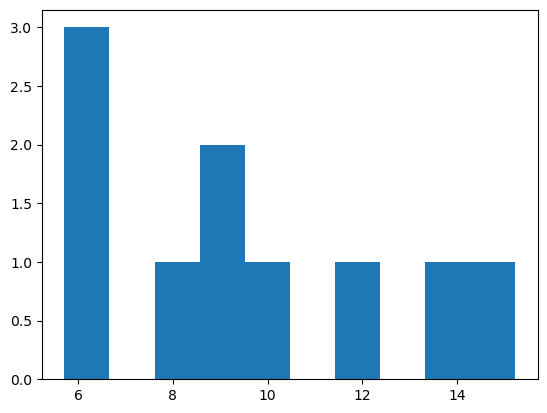

In [52]:
plt.hist(accuracies)
print(f"mean {np.mean(accuracies):.2f}% and std {np.std(accuracies):.2f}%")